# Chapter 4. Reinforcement Learning

$$ % Latex macros
\newcommand{\mat}[1]{\begin{pmatrix} #1 \end{pmatrix}}
\newcommand{\p}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\w}{\boldsymbol{w}}
\newcommand{\x}{\boldsymbol{x}}
$$

## Contents
* Bandit problem
* Markov decision process (MDP)
* Value functions
* Dynamic programming (DP)
* Q-learning and SARSA
* Actor-Critic
* Applications


* Neural Mechanisms
    * Dopamine neurons
    * Basal ganglia

In reinforcement learning, an *agent* interacts with the *environment* by observing its state, sending an action, and receiving some reward.

:::{figure-md} Fig_RL
 ![ReinforcementLearning](figures/RL.jpg)

Reinforcement learning in an agent-environment loop.
:::

The aim of reinforcemnet learning is to find a *policy*, a mapping $\pi$ from any state $s$ to an action $a$, that maximize the reward acquired.

* a deterministic policy $a=\pi(s)$
* a stochastic policy $\pi(s,a)=p(a|s)$

## Bandit problem
A simple case is that the state does not change, or change irrespective of the agent's action.
In this case, the problem is simply to estimate the expected reward for each action and pick the one with highest expected reward.

$$R(s,a) = E[r|s,a]$$
$$\pi(s) = \arg\max_a R(s,a)$$

## Markov decision process (MDP)
A general setup for reinforcement learning is the Markov decision process (MDP), which is characterized by 
* finite state $s \in S$  
* finite actions $a\in A(s)$
* state transition rule $P(s'|s,a)$
* reward function $R(s,a,s') = E[r|s,a,s']$

There are two conventions for the time index of reward. The reward following $a_t$ is denoted as $r_t$ or $r_{t+1}$ depending on the literature. Here we take the convention by Sutton and Barto (2018):
$$(s_t,a_t)\rightarrow (r_{t+1},s_{t+1})$$

In a dynamical environment, an action at time $t$ may affect the reward at later times $r_\tau$, $\tau > t$ through the state dynamics.  
From the other viewpoint, a reward at time $t$ may depend on all the past states and actions at $\tau<t$.

Thus in selecting an action, an agent needs to consider maximizing expected cumulative reward, called *return*
* finite horizon till time $T$: $R_t = r_{t+1} + r_{t+2} + ... + r_T$ 

* infinite horizon: $R_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ...$  
where $0\le\gamma<1$ is a *discount factor* to guarantee the sum to be finite.

## Value Functions
To evaluate the goodness of states, actions, and policy, a critical tool is the *value function*. There are two types.

* State value function: expected return starting from a state $s$ by following a policy $\pi$
$$V^\pi(s) \equiv E_\pi[R_t|s_t=s]\\ = E_\pi[\sum_k^\infty \gamma^k r_{t+k+1}|s_t=s]$$

* (State-)Action value function: expected return by taking an action $a$ at a state $s$, and then following a policy $\pi$
$$Q^\pi(s,a) \equiv E_\pi[R_t|s_t=s,a_t=a]\\ = E_\pi[\sum_k^\infty \gamma^k r_{t+k+1}|s_t=s,a_t=a]$$

An optimal policy $\pi^*$ for and MDP is defined as a policy that satisfies
$$V^{\pi^*}(s) \ge V^{\pi}(s)$$
for any state $s\in S$ and any policy $\pi$.

The value functions for an optimal policy is called *optimal value function* and denoted as $V^*(s)=V^{\pi^*}(s)$.  An MDP can have multiple optimal policies, but the optimal value function is unique.

An optimal state value function and action value function are related by
$$V^*(s) = \max_aQ^*(s,a)$$

## Solving MDPs
There are two main approaches in solving MDP problems

### Model-based approach: Dynamic programming
* The state transition function $p(s'|s,a)$ and the reward function $r(s,a)$ are known or learned
* Solve the *Bellman equation* for te optimal value function:
$$V^*(s) = \max_a E[ r(s,a) + \gamma V^*(s')]\\
= \max_a [r(s,a) + \sum_{s'}p(s'|s,a)\gamma V^*(s')] $$
* Use the optimal policy
$$a = \pi^*(s) = \arg\max_a E[ r(s,a) + \gamma V^*(s')]$$
* Representative algorithms:
    * Policy iteration
    * Value iteration

### Model-free approach: Reinforcement learning
* $p(s'|s,a)$ and $r(s,a)$ are unknown
* Learn from the sequence of experience:
$${s,a,r,s,a,r,…}$$
* Representative algorithms:
    * SARSA
    * Q-learning
    * Actor-Critic

## SARSA and Q Learning
* Estimate the action value function $Q(s,a)$ using a table or ANN.

* Select a action using the action value function
    * greedy: $a = \arg\max_a Q(s,a)$
    * $\epsilon$-greedy: random action with prob. $\epsilon$ and greedy with prob. $1-\epsilon$
    * Boltzman: $$p(a|s) = \frac{e^{\beta Q(s,a)}}{\sum_{b\in A}e^{\beta Q(s,b)}}$$

* Check the inconsistency of action value function estimates by the tempral difference (TD) error:
    * SARSA (on-policy)
$$\delta_t = r_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)$$
    * Q learning (off-policy) assuming greedy policy from the next state
$$\delta_t = r_{t+1} + \gamma \max_{a'\in A}Q(s_{t+1},a') - Q(s_t,a_t)$$

* Update the action value function of the previous state and action in proportion to the TD error
$$\Delta Q(s_t,a_t) = \alpha \delta_t$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Classes for minimum environment and agent

In [2]:
class Environment:
    """Class for a reinforcement learning environment"""
    
    def __init__(self, nstate=3, naction=2):
        """Create a new environment"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        
    def start(self):
        """start an episode"""
        # randomly pick a state
        self.state = np.random.randint(self.Ns)
        return(self.state)
    
    def step(self, action):
        """step by an action"""
        # random reward
        self.reward = np.random.random()  # between 0 and 1
        # random next state
        self.state = np.random.randint(self.Ns)
        return(self.reward, self.state)

In [3]:
class Agent:
    """Class for a reinforcement learning agent"""
    
    def __init__(self, nstate, naction):
        """Create a new agent"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        
    def start(self, state):
        """first action, without reward feedback"""
        # randomly pick an action
        self.action = np.random.randint(self.Na)
        return(self.action)
    
    def step(self, reward, state):
        """learn by reward and take an action"""
        # do nothing for reward
        # randomly pick an action
        self.action = np.random.randint(self.Na)
        return(self.action)

In [4]:
# Reinforcement non-learning
# Create the environment and the agent
env = Environment()
agent = Agent(env.Ns, env.Na)
# First contact
state = env.start()
action = agent.start(state)
print([state, action])
# Repeat interactoin
for t in range(10):
    reward, state = env.step(action)
    action = agent.step(reward, state)
    print([t, reward, state, action])

[2, 1]
[0, 0.7329453542748484, 1, 1]
[1, 0.008369138485483152, 0, 1]
[2, 0.013951629138464927, 1, 1]
[3, 0.9924415967951111, 0, 1]
[4, 0.9141672175446494, 0, 0]
[5, 0.7789706682815795, 0, 1]
[6, 0.9350705536927093, 2, 0]
[7, 0.7103132431773079, 0, 1]
[8, 0.9950737337637371, 2, 1]
[9, 0.9684136180188804, 2, 0]


In [5]:
class RL:
    """Reinforcement learning by interacton of Environment and Agent"""

    def __init__(self, environment, agent, nstate, naction):
        """Create the environment and the agent"""
        self.env = environment(nstate, naction)
        self.agent = agent(nstate, naction)
    
    def episode(self, tmax=50):
        """One episode"""
        # First contact
        state = self.env.start()
        action = self.agent.start(state)
        # Table of t, r, s, a
        Trsa = np.zeros((tmax+1, 4))
        Trsa[0] = [0, 0, state, action]
        # Repeat interactoin
        for t in range(1, tmax+1):
            reward, state = self.env.step(action)
            action = self.agent.step(reward, state)
            Trsa[t,:] = [t, reward, state, action]
        return(Trsa)
    
    def run(self, nrun=10, tmax=50):
        """Multiple runs of episodes"""
        Return = np.zeros(nrun)
        for n in range(nrun):
            r = self.episode(tmax)[:,1]  # reward sequence
            Return[n] = sum(r)
        return(Return)

### Example: Pain-Gain environment

:::{figure-md} Fig_PainGain
![PainGain](figures/PainGain.jpg)

The Pain-Gain environment.
:::

This is a Markov Decision Process that was designed for a functional MRI experiment (Tanaka et al. 2004).
The environment has four states and two possible actions.
By taking action 1, the state shift to the left and a positive reward is given, except at the leftmost state where it a big negative reward is given.
By action 2, the state shift to the right and a negative reward is given, but at the rightmost state, a big positive reward is obtained.
What is the right policy?

In [6]:
class PainGain(Environment):
    """Pain-Gain environment """
    
    def __init__(self, nstate=4, naction=2, gain=6):
        super().__init__(nstate, naction)
        # setup the reward function as an array
        self.R = np.ones((self.Ns, self.Na)) # small gains
        self.R[:,1] = -1   # small pains for 2nd action (a=1)
        self.R[0,0] = -gain  # large pain
        self.R[-1,1] = gain  # large gain
    
    def step(self, action):
        """step by an action"""
        # reward by the reward matrix
        self.reward = self.R[self.state, action]
        # move left or right and circle
        self.state = (self.state + 2*action-1)%self.Ns  
        return(self.reward, self.state)

In [7]:
class QL(Agent):
    """Class for a Q-learning agent"""

    def __init__(self, nstate, naction):
        super().__init__(nstate, naction)
        # allocate Q table
        self.Q = np.zeros((nstate, naction))
        # default parameters
        self.alpha = 0.1  # learning rate
        self.beta = 1.0   # inverse temperature
        self.gamma = 0.9  # discount factor
    
    def boltzmann(self, q):
        """Boltzmann selection"""
        p = np.exp( self.beta*q)   # unnormalized probability
        p = p/sum(p)    # probability
        # sample by multinoulli (categorical) distribution
        s = np.random.multinomial(1,p)
        return list(s).index(1)  # find the index of 1
        #return(np.searchsorted( np.cumsum(p), np.random.random()))

    def start(self, state):
        """first action, without reward feedback"""
        # Boltzmann action selection
        self.action = self.boltzmann( self.Q[state,:])
        # remember the state
        self.state = state
        return(self.action)
    
    def step(self, reward, state):
        """learn by reward and take an action"""
        # TD error: self.state/action retains the previous ones
        delta = reward + self.gamma*max(self.Q[state,:]) - self.Q[self.state,self.action]
        # Update the value for previous state and action
        self.Q[self.state,self.action] += self.alpha*delta
        # Boltzmann action selection
        self.action = self.boltzmann( self.Q[state,:])
        # remember the state
        self.state = state
        return(self.action)

In [8]:
# Pain-Gain environment and Q-learning agent
pgq = RL(PainGain, QL, 4, 2)
# customize parameters
pgq.agent.beta = 1

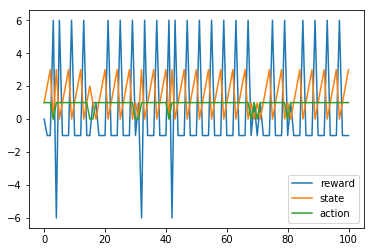

In [14]:
# run an episode
trsa = pgq.episode(100)
plt.plot(trsa[:,1:]);
plt.legend(("reward", "state", "action"));

In [ ]:
# Visualize Q function
plt.bar(np.arange(4)-0.2, pgq.agent.Q[:,0], 0.4 )  # action0
plt.bar(np.arange(4)+0.2, pgq.agent.Q[:,1], 0.4 );  # action1

In [ ]:
# Repeat episodes for learning curve
pgq = RL(PainGain, QL, 4, 2)
R = pgq.run(50, 10)
plt.plot(R);

## Actor-Critic
Another popular class of RL is *Actor-Critic*.

Actor implements a policy $\pi_\w=p(a|s;\w)$, where $\w$ is the parameter, such as the elements of a table or the weights of an ANN.

Critic learns the state value function of the actor's policy $\pi_\w$:
$$V^{\pi_\w}(s) = E_{\pi_\w}[ r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ...|s_t=s]$$
using a table or an ANN.

Learning is based on the temporal difference (TD) error:
$$\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$$

The TD error is used for learning of both critic and actor, but in different ways:

Critic: $\Delta V(s_t) = \alpha \delta_t$

Actor: $\Delta \w = \alpha_w \delta_t \p{p(a_t|s_t;\w)}{\w}$  or
$$\Delta \w = \alpha_w \delta_t \p{\log p(a_t|s_t;\w)}{\w}$$

## Dopamine neurons
Dopamine neurons in the midbrain appear to code TD error.

% ![Dopamine](figures/Schultz97.jpg)

## Basal ganglia

:::{figure-md} Fig_BG
![BGforRL](figures/BGRL.jpg)

A reinforcement learning model of the basal ganglia.
:::

## References

* Sutton RS, Barto AG (2018). Reinforcement Learning: An Introduction, 2nd edition. MIT Press.  
(http://incompleteideas.net/book/the-book-2nd.html)

* Barto AG, Sutton RS, Andersen CW (1983). Neuronlike adaptive elements that can solve difficult learning control problems. IEEE Transactions on Systems, Man, and Cybernetics, 13, 834-846. 
http://doi.org/10.1109/TSMC.1983.6313077

* Doya K (2007). Reinforcement learning: Computational theory and biological mechanisms. HFSP J, 1, 30-40.
http://doi.org/10.2976/1.2732246/10.2976/1


### Dopamine neurons

* Schultz W, Dayan P, Montague PR (1997). A Neural Substrate of Prediction and Reward. Science, 275, 1593-1599. 
http://doi.org/10.1126/science.275.5306.1593

* Nomoto K, Schultz W, Watanabe T, Sakagami M (2010). Temporally extended dopamine responses to perceptually demanding reward-predictive stimuli. J Neurosci, 30, 10692-702. 
http://doi.org/10.1523/JNEUROSCI.4828-09.2010


### Basal ganglia

* Samejima K, Ueda Y, Doya K, Kimura M (2005). Representation of action-specific reward values in the striatum. Science, 310, 1337-40.
http://doi.org/10.1126/science.1115270

* Ito M, Doya K (2015). Distinct neural representation in the dorsolateral, dorsomedial, and ventral parts of the striatum during fixed- and free-choice tasks. Journal of Neuroscience, 35, 3499-3514. http://doi.org/10.1523/JNEUROSCI.1962-14.2015